# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import optuna
import warnings

from collections import Counter
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix


warnings.filterwarnings("ignore")

# Model Pipeline

In [ ]:
class CatBoostPipeline:
    """
    Class to preprocess the dataset and train the CatBoost model

    Attributes:
        train_df : DataFrame : Training DataFrame
        test_df : DataFrame : Test DataFrame
        categorical_features : List : Categorical features in the dataset
        numerical_features : List : Numerical features in the dataset
        model : CatBoostClassifier : Trained CatBoost model
        top_prop_categories : List : Top categories for 'proto' column
        top_service_categories : List : Top categories for 'service' column
        top_state_categories : List : Top categories for 'state' column
        corr_threshold : float : Correlation threshold for removing highly correlated features
        features_to_drop : List : Features to drop from the dataset

    Methods:
        basic_cleaning : Perform basic cleaning on the dataset
        identify_feature_types : Identify the feature types in the dataset
        handle_outliers : Handle outliers in the dataset
        convert_data_types : Convert the data types of the columns in the dataset
        selecting_categories : Select the top categories for the 'proto', 'service', and 'state' columns
        transform_categories : Transform the categories in the 'proto', 'service', and 'state' columns
        create_log1p_features : Create log1p features for the numerical columns in the dataset
        remove_highly_correlated_features : Remove highly correlated features from the dataset
        preprocess : Perform preprocessing on the dataset
        create_pool : Create a CatBoost Pool object
        train_model : Train the CatBoost model
        objective : Objective function for Optuna hyperparameter tuning
        optuna_tuning : Perform hyperparameter tuning using Optuna
        train_with_optuna : Train the CatBoost model with hyperparameter tuning using Optuna

    """
    def __init__(self, train_file_path, test_file_path):
        self.train_df = pd.read_parquet(train_file_path)
        self.test_df = pd.read_parquet(test_file_path)
        self.categorical_features = []
        self.numerical_features = []
        self.model = None
        self.top_prop_categories = None
        self.top_service_categories = None
        self.top_state_categories = None
        self.corr_threshold = 0.9
        self.features_to_drop = []  # Store features to drop

    def basic_cleaning(self, df):
        """
        Perform basic cleaning on the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            df :DataFrame : Cleaned DataFrame
        """
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'label', 'is_sm_ips_ports', 'response_body_len', 'rate']
        df = df[~df['attack_cat'].isin(['Normal', 'Analysis', 'Shellcode', 'Worms', 'Backdoor'])]
        epsilon = 1e-10  # Small constant to avoid division by zero

        df["Speed of Operations to Speed of Data Bytes"] = np.log1p(df["sbytes"] / (df["dbytes"] + epsilon))
        df["Time for a Single Process"] = np.log1p(df["dur"] / (df["spkts"] + epsilon))
        df["Ratio of Data Flow"] = np.log1p(df["dbytes"] / (df["sbytes"] + epsilon))
        df["Ratio of Packet Flow"] = np.log1p(df["dpkts"] / (df["spkts"] + epsilon))
        df["Total Page Errors"] = np.log1p(df["dur"] * df["sloss"])
        df["Network Usage"] = np.log1p(df["sbytes"] + df["dbytes"])
        df["Network Activity Rate"] = np.log1p(df["spkts"] + df["dpkts"])
        
        return df.drop(columns=columns_to_drop, axis=1)

    def identify_feature_types(self, df):
        """
        Identify the feature types in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            None
        """
        self.categorical_features = df.select_dtypes(include=['category', 'object']).columns.tolist()
        self.numerical_features = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32']).columns.tolist()
        self.categorical_features = [col for col in self.categorical_features if col != 'attack_cat']

    def handle_outliers(self, df):
        """
        Handle outliers in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with outliers handled
        """
        for column in self.numerical_features:
            lower_bound = df[column].quantile(0.001)
            upper_bound = df[column].quantile(0.999)
            df[column] = df[column].clip(lower_bound, upper_bound)
        return df

    def convert_data_types(self, df):
        """
        Convert the data types of the columns in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with converted data types
        """
        for column in self.categorical_features:
            df[column] = df[column].astype('category')
        for column in self.numerical_features:
            df[column] = df[column].astype('float32')
        return df

    def selecting_categories(self, df):
        """
        Select the top categories for the 'proto', 'service', and 'state' columns

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            Tuple : Top categories for 'proto', 'service', and 'state' columns
        """
        top_prop_categories = df['proto'].value_counts().head().index
        top_service_categories = df['service'].value_counts().head().index
        top_state_categories = df['state'].value_counts().head(5).index
        return top_prop_categories, top_service_categories, top_state_categories

    def transform_categories(self, df, top_prop_categories, top_service_categories, top_state_categories):
        """
        Transform the categories in the 'proto', 'service', and 'state' columns

        Args:
            df : DataFrame : Input DataFrame
            top_prop_categories : List : Top categories for 'proto' column
            top_service_categories : List : Top categories for 'service' column
            top_state_categories : List : Top categories for 'state' column

        Returns:
            DataFrame : DataFrame with transformed categories
        """
        df['proto'] = np.where(df['proto'].isin(top_prop_categories), df['proto'], '-')
        df['service'] = np.where(df['service'].isin(top_service_categories), df['service'], '-')
        df['state'] = np.where(df['state'].isin(top_state_categories), df['state'], '-')
        return df

    def create_log1p_features(self, df):
        """
        Create log1p features for the numerical columns in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with log1p features
        """
        log_features = [
            'smean', 'dmean',
            'sinpkt', 'dinpkt', 'sload', 'dload', 'sbytes', 'dbytes',
            'sjit', 'djit',
        ]
        for feature in log_features:
            if feature in df.columns:
                df[feature] = np.log1p(df[feature])

        return df
    
    def remove_highly_correlated_features(self, df, is_train=True):
        """
        Remove highly correlated features from the dataset

        Args:
            df : DataFrame : Input DataFrame
            is_train : bool : Whether the dataset is the training set

        Returns:
            DataFrame : DataFrame with highly correlated features removed
        """
        if is_train:
            corr_matrix = df[self.numerical_features].corr().abs()  # Get the correlation matrix of numerical features
            upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            # Find features that have a correlation greater than the threshold
            self.features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > self.corr_threshold)]
            print(f"Removing highly correlated features in training: {self.features_to_drop}")
        else:
            print(f"Removing same highly correlated features in test: {self.features_to_drop}")
        
        # Drop the highly correlated features (based on train set) from the dataframe
        df = df.drop(columns=self.features_to_drop, axis=1)

        # Update the numerical features list after dropping the highly correlated features
        self.numerical_features = [col for col in self.numerical_features if col not in self.features_to_drop]
        return df


    def preprocess(self, is_train=True):
        """
        Perform preprocessing on the dataset

        Args:
            is_train : bool : Whether the dataset is the training set

        Returns:
            Tuple : X, y
        """
        # Get the DataFrame based on whether it is the training set or not
        df = self.train_df if is_train else self.test_df

        # Basic cleaning
        df = self.basic_cleaning(df)

        # Identify feature types
        self.identify_feature_types(df)

        # Handle outliers
        df = self.handle_outliers(df) if is_train else df

        # Select top categories
        self.top_prop_categories, self.top_service_categories, self.top_state_categories = self.selecting_categories(df) if is_train else (self.top_prop_categories, self.top_service_categories, self.top_state_categories)

        # Transform categories
        df = self.transform_categories(df, self.top_prop_categories, self.top_service_categories, self.top_state_categories)
        
        # Log1p Feature Creation
        df = self.create_log1p_features(df)

        # Remove highly correlated features (use same features for both train and test)
        df = self.remove_highly_correlated_features(df, is_train=is_train)

        # Convert data types
        df = self.convert_data_types(df)
        
        # Separate features and target
        X = df.drop('attack_cat', axis=1)
        y = df['attack_cat']

        return X, y

    def create_pool(self, X, y=None):
        """
        Create a CatBoost Pool object

        Args:
            X : DataFrame : Input DataFrame
            y : DataFrame : Target DataFrame

        Returns:
            Pool : CatBoost Pool object
        """
        return Pool(
            data=X,
            label=y,
            cat_features=self.categorical_features
        )

    def calculate_class_weights(self, y):
        """
        Calculate class weights for multi-class classification based on class frequencies.

        Args:
            y : Series : Target labels

        Returns:
            dict : Class weights dictionary where keys are class indices and values are weights
        """
        class_counts = Counter(y)
        total_samples = len(y)
        class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}
        return class_weights

    def train_model(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the CatBoost model for multi-class classification.

        Args:
            X_train : DataFrame : Training features
            y_train : Series : Training target
            X_val : DataFrame : Validation features (optional)
            y_val : Series : Validation target (optional)

        Returns:
            CatBoostClassifier : Trained CatBoost model
        """
        train_pool = self.create_pool(X_train, y_train)
        val_pool = self.create_pool(X_val, y_val) if X_val is not None else None

        # Calculate multi-class weights
        class_weights = self.calculate_class_weights(y_train)

        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function='MultiClass',
            eval_metric='MultiClass',
            task_type='GPU',
            random_seed=17,
            class_weights=class_weights,  # Apply class weights for multi-class
            verbose=100
        )

        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=100
        )

        return model

    def objective(self, trial, X_train, y_train, X_val, y_val):
        """
        Objective function for Optuna hyperparameter tuning for multi-class classification.

        Args:
            trial : Trial : Optuna trial object
            X_train : DataFrame : Training features
            y_train : Series : Training target
            X_val : DataFrame : Validation features
            y_val : Series : Validation target

        Returns:
            float : MultiClass F1 score
        """
        try:
            # Define the hyperparameters to be tuned
            params = {
                'iterations': trial.suggest_int('iterations', 800, 1200),
                'learning_rate': trial.suggest_float('learning_rate', 5e-2, 2e-1),
                'depth': trial.suggest_int('depth', 4, 12),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0),
                'random_seed': 17,
                'loss_function': 'MultiClass',
                'eval_metric': 'MultiClass',
                'task_type': 'GPU',
                'class_weights': self.calculate_class_weights(y_train),  # Apply multi-class weights
            }

            train_pool = self.create_pool(X_train, y_train)
            val_pool = self.create_pool(X_val, y_val)

            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=100)

            predictions = model.predict(val_pool)

            # Return the validation F1 score
            val_score = f1_score(y_val, predictions, average='weighted')
            return val_score

        except Exception as e:
            print(f"Error in objective function: {e}")
            return 0.0  # Return a default score in case of error

    def optuna_tuning(self, X_train, y_train, X_val, y_val, n_trials=50):
        """
        Perform hyperparameter tuning using Optuna

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target
            n_trials : int : Number of Optuna trials

        Returns:
            Dict : Best hyperparameters
        """
        try:
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: self.objective(trial, X_train, y_train, X_val, y_val), n_trials=n_trials)

            # Print and return the best parameters found by Optuna
            print("Best hyperparameters: ", study.best_params)
            print("Best F1: ", study.best_value)

            return study.best_params

        except Exception as e:
            print(f"Error in Optuna tuning: {e}")
            return None  # Return None if tuning fails

    def train_with_optuna(self, X_train, y_train, X_val, y_val,tune = True, n_trials=50):
        """
        Train the CatBoost model with hyperparameter tuning using Optuna

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target
            n_trials : int : Number of Optuna trials

        Returns:
            CatBoostClassifier : Trained CatBoost model
        """
        try:
            if(tune):
                # Tune hyperparameters
                best_params = self.optuna_tuning(X_train, y_train, X_val, y_val, n_trials)

                if best_params is None:
                    print("Optuna tuning failed. Exiting training process.")
                    return None  # Exit if tuning failed
            else:
                best_params = {'iterations': 1117, 'learning_rate': 0.09100148551636808, 'depth': 7, 'l2_leaf_reg': 0.8791036277340738}
            # Train the model with the best hyperparameters
            train_pool = self.create_pool(X_train, y_train)
            val_pool = self.create_pool(X_val, y_val)

            fixed_params = {
                'class_weights': self.calculate_class_weights(y_train),  # Apply multi-class weights
                'loss_function': 'MultiClass',
                'eval_metric': 'MultiClass',
                'random_seed': 17,
                'task_type': 'GPU',
                'verbose': 100,
            }
            model = CatBoostClassifier(
                **best_params,
                **fixed_params
            )

            model.fit(
                train_pool,
                eval_set=val_pool,
            )

            return model

        except Exception as e:
            print(f"Error during training with Optuna: {e}")
            return None  # Return None if training fails


In [ ]:
# Define the paths to the training and testing datasets
train_path = ''
test_path = ''

In [4]:
# Usage example
pipeline = CatBoostPipeline(train_path, test_path)

# Preprocess training data
X_train, y_train = pipeline.preprocess(is_train=True)
X_test, y_test = pipeline.preprocess(is_train=False)

# Split into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=17)

Removing highly correlated features in training: ['dload', 'sloss', 'sinpkt', 'sjit', 'djit', 'synack', 'ackdat', 'dmean', 'ct_dst_sport_ltm', 'ct_ftp_cmd']
Removing same highly correlated features in test: ['dload', 'sloss', 'sinpkt', 'sjit', 'djit', 'synack', 'ackdat', 'dmean', 'ct_dst_sport_ltm', 'ct_ftp_cmd']


In [5]:
# Train baseline model
model = pipeline.train_model(X_train, y_train, X_val, y_val)

0:	learn: 1.4114407	test: 1.4007927	best: 1.4007927 (0)	total: 6.74s	remaining: 1h 52m 18s
100:	learn: 0.5050149	test: 0.5293791	best: 0.5293791 (100)	total: 7.83s	remaining: 1m 9s
200:	learn: 0.4811017	test: 0.5093723	best: 0.5093723 (200)	total: 8.97s	remaining: 35.7s
300:	learn: 0.4692033	test: 0.5026624	best: 0.5026624 (300)	total: 9.96s	remaining: 23.1s
400:	learn: 0.4618754	test: 0.4998559	best: 0.4998559 (400)	total: 10.9s	remaining: 16.3s
500:	learn: 0.4561443	test: 0.4984227	best: 0.4980885 (492)	total: 11.9s	remaining: 11.9s
600:	learn: 0.4517095	test: 0.4972566	best: 0.4972310 (599)	total: 12.9s	remaining: 8.54s
700:	learn: 0.4480247	test: 0.4973183	best: 0.4971726 (604)	total: 13.8s	remaining: 5.89s
800:	learn: 0.4447980	test: 0.4972962	best: 0.4971726 (604)	total: 14.8s	remaining: 3.67s
900:	learn: 0.4419448	test: 0.4970059	best: 0.4969236 (897)	total: 15.7s	remaining: 1.73s
999:	learn: 0.4393568	test: 0.4968284	best: 0.4965829 (986)	total: 16.7s	remaining: 0us
bestTest = 

In [6]:
# Create test pool and make predictions
test_pool = pipeline.create_pool(X_test)
predictions = model.predict(test_pool)
predictions_prob = model.predict_proba(test_pool)[:, 1]

F1 Score: 0.8355941599641689
Precision: 0.8673680087418902
Recall: 0.8244215349369989


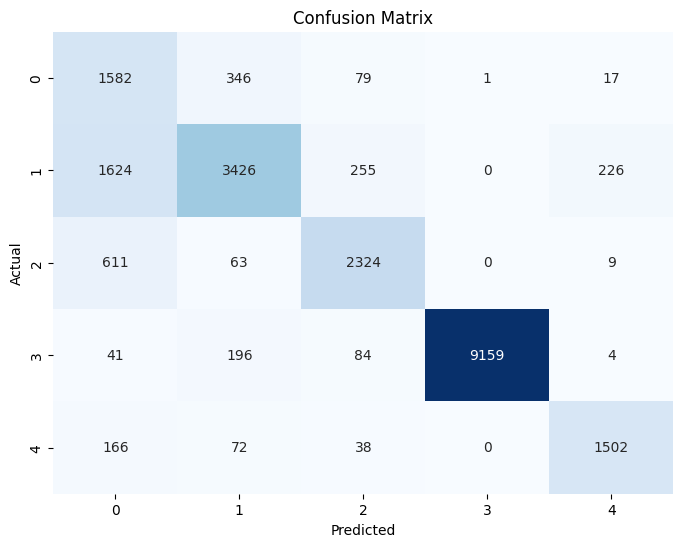

In [7]:
# Compute metrics for multi-class classification
f1 = f1_score(y_test, predictions, average='weighted')  # Macro average for multi-class
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, predictions)
# Display the report
print(report)

                precision    recall  f1-score   support

           DoS       0.39      0.78      0.52      2025
      Exploits       0.83      0.62      0.71      5531
       Fuzzers       0.84      0.77      0.80      3007
       Generic       1.00      0.97      0.98      9484
Reconnaissance       0.85      0.84      0.85      1778

      accuracy                           0.82     21825
     macro avg       0.78      0.80      0.77     21825
  weighted avg       0.87      0.82      0.84     21825



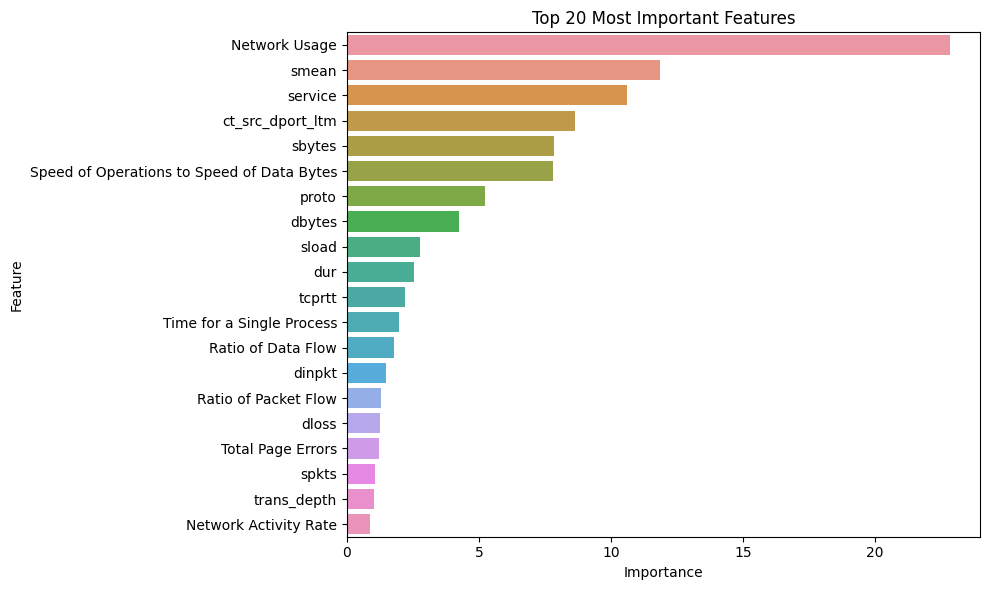

In [9]:
# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

def plot_feature_importance(top_n=20):
    """Plots the top N important features."""

    # Select top N features
    top_features = features_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance()

In [10]:
# Train the model with hyperparameter tuning
model = pipeline.train_with_optuna(X_train, y_train, X_val, y_val, tune=True, n_trials=50)

[I 2024-11-05 20:07:59,557] A new study created in memory with name: no-name-f9fe9dcc-aef7-45de-97f6-1fc3778a9367


0:	learn: 1.2552786	test: 1.2484041	best: 1.2484041 (0)	total: 50.5ms	remaining: 46s
100:	learn: 0.4478788	test: 0.5045718	best: 0.5033008 (81)	total: 4.68s	remaining: 37.6s
bestTest = 0.5033007898
bestIteration = 81
Shrink model to first 82 iterations.


[I 2024-11-05 20:08:08,699] Trial 0 finished with value: 0.8336775637084934 and parameters: {'iterations': 913, 'learning_rate': 0.16325912496057554, 'depth': 10, 'l2_leaf_reg': 0.5958217718024176}. Best is trial 0 with value: 0.8336775637084934.


0:	learn: 1.3951408	test: 1.3885407	best: 1.3885407 (0)	total: 20.4ms	remaining: 17s
100:	learn: 0.4843931	test: 0.5166235	best: 0.5166235 (100)	total: 1.79s	remaining: 13s
200:	learn: 0.4598634	test: 0.5026241	best: 0.5024971 (197)	total: 3.58s	remaining: 11.2s
300:	learn: 0.4471693	test: 0.5027456	best: 0.5022743 (284)	total: 5.37s	remaining: 9.47s
400:	learn: 0.4385887	test: 0.5030230	best: 0.5019300 (338)	total: 7.15s	remaining: 7.69s
bestTest = 0.5019300164
bestIteration = 338
Shrink model to first 339 iterations.


[I 2024-11-05 20:08:17,476] Trial 1 finished with value: 0.834709521583443 and parameters: {'iterations': 832, 'learning_rate': 0.09852345444547242, 'depth': 8, 'l2_leaf_reg': 0.6716454563218158}. Best is trial 1 with value: 0.834709521583443.


0:	learn: 1.2999953	test: 1.2891015	best: 1.2891015 (0)	total: 15.3ms	remaining: 16.1s
100:	learn: 0.4766045	test: 0.5101897	best: 0.5100195 (95)	total: 1.27s	remaining: 12s
200:	learn: 0.4554955	test: 0.5026540	best: 0.5024201 (197)	total: 2.74s	remaining: 11.7s
300:	learn: 0.4438777	test: 0.5009749	best: 0.5008905 (292)	total: 4.04s	remaining: 10.2s
400:	learn: 0.4366995	test: 0.5021401	best: 0.5008051 (314)	total: 5.32s	remaining: 8.7s
bestTest = 0.5008051326
bestIteration = 314
Shrink model to first 315 iterations.


[I 2024-11-05 20:08:23,853] Trial 2 finished with value: 0.8360435154465309 and parameters: {'iterations': 1057, 'learning_rate': 0.1516145418091936, 'depth': 7, 'l2_leaf_reg': 0.6943832115370324}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4186526	test: 1.4083695	best: 1.4083695 (0)	total: 12.5ms	remaining: 10.7s
100:	learn: 0.5049336	test: 0.5289661	best: 0.5289661 (100)	total: 975ms	remaining: 7.34s
200:	learn: 0.4809680	test: 0.5092800	best: 0.5092800 (200)	total: 1.92s	remaining: 6.32s
300:	learn: 0.4691426	test: 0.5031174	best: 0.5031174 (300)	total: 2.86s	remaining: 5.33s
400:	learn: 0.4616813	test: 0.5007504	best: 0.5005008 (395)	total: 3.81s	remaining: 4.38s
500:	learn: 0.4554799	test: 0.4989262	best: 0.4986354 (490)	total: 4.77s	remaining: 3.44s
600:	learn: 0.4505423	test: 0.4979437	best: 0.4978492 (598)	total: 5.72s	remaining: 2.48s
700:	learn: 0.4465169	test: 0.4967904	best: 0.4967904 (700)	total: 6.72s	remaining: 1.54s
800:	learn: 0.4429890	test: 0.4969526	best: 0.4967540 (703)	total: 7.67s	remaining: 584ms
bestTest = 0.496754029
bestIteration = 703
Shrink model to first 704 iterations.


[I 2024-11-05 20:08:32,578] Trial 3 finished with value: 0.8351854790222498 and parameters: {'iterations': 862, 'learning_rate': 0.09609749891154859, 'depth': 6, 'l2_leaf_reg': 0.8342360104519634}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4215845	test: 1.4054122	best: 1.4054122 (0)	total: 8.86ms	remaining: 9.11s
100:	learn: 0.5269138	test: 0.5506338	best: 0.5506338 (100)	total: 663ms	remaining: 6.09s
200:	learn: 0.5013601	test: 0.5238968	best: 0.5238968 (200)	total: 1.29s	remaining: 5.33s
300:	learn: 0.4899380	test: 0.5154522	best: 0.5154522 (300)	total: 1.9s	remaining: 4.6s
400:	learn: 0.4815527	test: 0.5103977	best: 0.5103235 (394)	total: 2.58s	remaining: 4.04s
500:	learn: 0.4753998	test: 0.5064812	best: 0.5064812 (500)	total: 3.22s	remaining: 3.39s
600:	learn: 0.4712706	test: 0.5049518	best: 0.5047333 (592)	total: 3.87s	remaining: 2.76s
700:	learn: 0.4681870	test: 0.5037160	best: 0.5036929 (697)	total: 4.49s	remaining: 2.1s
800:	learn: 0.4649027	test: 0.5027652	best: 0.5026071 (783)	total: 5.1s	remaining: 1.45s
bestTest = 0.50260715
bestIteration = 783
Shrink model to first 784 iterations.


[I 2024-11-05 20:08:39,141] Trial 4 finished with value: 0.8328549636577718 and parameters: {'iterations': 1029, 'learning_rate': 0.11593480545579243, 'depth': 4, 'l2_leaf_reg': 0.9305382238348834}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2090429	test: 1.2008090	best: 1.2008090 (0)	total: 29.9ms	remaining: 34s
100:	learn: 0.4526085	test: 0.5060889	best: 0.5056836 (97)	total: 2.84s	remaining: 29.2s
200:	learn: 0.4312052	test: 0.5070832	best: 0.5047596 (129)	total: 5.63s	remaining: 26.2s
bestTest = 0.5047595839
bestIteration = 129
Shrink model to first 130 iterations.


[I 2024-11-05 20:08:46,527] Trial 5 finished with value: 0.8336553478778854 and parameters: {'iterations': 1138, 'learning_rate': 0.1920128535670672, 'depth': 9, 'l2_leaf_reg': 0.6353496231604129}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4640103	test: 1.4560946	best: 1.4560946 (0)	total: 12ms	remaining: 9.82s
100:	learn: 0.5179330	test: 0.5434875	best: 0.5434875 (100)	total: 980ms	remaining: 6.95s
200:	learn: 0.4899203	test: 0.5176600	best: 0.5176600 (200)	total: 1.93s	remaining: 5.93s
300:	learn: 0.4773587	test: 0.5089096	best: 0.5089096 (300)	total: 2.88s	remaining: 4.95s
400:	learn: 0.4689564	test: 0.5044067	best: 0.5044067 (400)	total: 3.84s	remaining: 3.99s
500:	learn: 0.4621179	test: 0.5014221	best: 0.5014221 (500)	total: 4.99s	remaining: 3.16s
600:	learn: 0.4572926	test: 0.4999521	best: 0.4998226 (585)	total: 6.01s	remaining: 2.17s
700:	learn: 0.4534281	test: 0.4992068	best: 0.4991539 (676)	total: 6.98s	remaining: 1.16s
800:	learn: 0.4498174	test: 0.4983823	best: 0.4982753 (792)	total: 7.95s	remaining: 169ms
817:	learn: 0.4492139	test: 0.4983677	best: 0.4982753 (792)	total: 8.11s	remaining: 0us
bestTest = 0.4982752892
bestIteration = 792
Shrink model to first 793 iterations.


[I 2024-11-05 20:08:55,536] Trial 6 finished with value: 0.8342809835188697 and parameters: {'iterations': 818, 'learning_rate': 0.07222137835041297, 'depth': 6, 'l2_leaf_reg': 0.4908896881161181}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4332507	test: 1.4301762	best: 1.4301762 (0)	total: 80.5ms	remaining: 1m 11s
100:	learn: 0.4699698	test: 0.5118323	best: 0.5118323 (100)	total: 8.12s	remaining: 1m 3s
200:	learn: 0.4436617	test: 0.5042483	best: 0.5040896 (191)	total: 16.2s	remaining: 55.8s
bestTest = 0.5040896055
bestIteration = 191
Shrink model to first 192 iterations.


[I 2024-11-05 20:09:20,047] Trial 7 finished with value: 0.8329433803753963 and parameters: {'iterations': 893, 'learning_rate': 0.07552844621424255, 'depth': 11, 'l2_leaf_reg': 0.9606866051542035}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4321506	test: 1.4290591	best: 1.4290591 (0)	total: 81.8ms	remaining: 1m 9s
100:	learn: 0.4699058	test: 0.5110993	best: 0.5110993 (100)	total: 8.29s	remaining: 1m 1s
200:	learn: 0.4431155	test: 0.5076420	best: 0.5063343 (157)	total: 16.4s	remaining: 53.2s
bestTest = 0.5063342622
bestIteration = 157
Shrink model to first 158 iterations.


[I 2024-11-05 20:09:42,009] Trial 8 finished with value: 0.8331319397831825 and parameters: {'iterations': 854, 'learning_rate': 0.07601773707680731, 'depth': 11, 'l2_leaf_reg': 0.8342014411922536}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2311769	test: 1.2255262	best: 1.2255262 (0)	total: 79.4ms	remaining: 1m 11s
100:	learn: 0.4375646	test: 0.5102205	best: 0.5080291 (72)	total: 8.15s	remaining: 1m 4s
bestTest = 0.5080291406
bestIteration = 72
Shrink model to first 73 iterations.


[I 2024-11-05 20:09:57,126] Trial 9 finished with value: 0.8314811203488623 and parameters: {'iterations': 904, 'learning_rate': 0.172558705651756, 'depth': 11, 'l2_leaf_reg': 0.5909298830750159}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3205353	test: 1.3102443	best: 1.3102443 (0)	total: 16.4ms	remaining: 19.3s
100:	learn: 0.4795600	test: 0.5149253	best: 0.5149253 (100)	total: 1.3s	remaining: 13.9s
200:	learn: 0.4577179	test: 0.5043874	best: 0.5040736 (198)	total: 2.55s	remaining: 12.4s
300:	learn: 0.4452422	test: 0.5040075	best: 0.5032471 (254)	total: 3.84s	remaining: 11.2s
bestTest = 0.5032470689
bestIteration = 254
Shrink model to first 255 iterations.


[I 2024-11-05 20:10:02,545] Trial 10 finished with value: 0.833115105736013 and parameters: {'iterations': 1180, 'learning_rate': 0.14049266267710725, 'depth': 7, 'l2_leaf_reg': 0.221864681817262}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3672207	test: 1.3540503	best: 1.3540503 (0)	total: 10.3ms	remaining: 10.5s
100:	learn: 0.5050369	test: 0.5259959	best: 0.5259959 (100)	total: 789ms	remaining: 7.22s
200:	learn: 0.4819372	test: 0.5074196	best: 0.5074196 (200)	total: 1.53s	remaining: 6.28s
300:	learn: 0.4708637	test: 0.5015323	best: 0.5011416 (283)	total: 2.29s	remaining: 5.52s
400:	learn: 0.4639690	test: 0.4993131	best: 0.4993131 (400)	total: 3.04s	remaining: 4.74s
500:	learn: 0.4578640	test: 0.4981787	best: 0.4980817 (493)	total: 3.8s	remaining: 3.98s
600:	learn: 0.4532212	test: 0.4977199	best: 0.4972278 (577)	total: 4.56s	remaining: 3.22s
700:	learn: 0.4497128	test: 0.4967805	best: 0.4965705 (671)	total: 5.3s	remaining: 2.46s
bestTest = 0.4965705298
bestIteration = 671
Shrink model to first 672 iterations.


[I 2024-11-05 20:10:09,310] Trial 11 finished with value: 0.8340678930066274 and parameters: {'iterations': 1026, 'learning_rate': 0.135139923769801, 'depth': 5, 'l2_leaf_reg': 0.7787991598619992}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3778177	test: 1.3693274	best: 1.3693274 (0)	total: 15.3ms	remaining: 16.8s
100:	learn: 0.4872375	test: 0.5138247	best: 0.5138247 (100)	total: 1.32s	remaining: 13s
200:	learn: 0.4642759	test: 0.5027222	best: 0.5027222 (200)	total: 2.56s	remaining: 11.4s
300:	learn: 0.4530041	test: 0.5003951	best: 0.5000186 (288)	total: 3.83s	remaining: 10.1s
400:	learn: 0.4447616	test: 0.4993007	best: 0.4982729 (339)	total: 5.07s	remaining: 8.76s
bestTest = 0.498272942
bestIteration = 339
Shrink model to first 340 iterations.


[I 2024-11-05 20:10:15,768] Trial 12 finished with value: 0.8357783438962468 and parameters: {'iterations': 1094, 'learning_rate': 0.11049759059853559, 'depth': 7, 'l2_leaf_reg': 0.4022429474345257}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2894112	test: 1.2801740	best: 1.2801740 (0)	total: 20.9ms	remaining: 22.8s
100:	learn: 0.4681300	test: 0.5067644	best: 0.5065758 (97)	total: 1.8s	remaining: 17.7s
200:	learn: 0.4460294	test: 0.5055399	best: 0.5034063 (134)	total: 3.58s	remaining: 15.9s
bestTest = 0.5034063388
bestIteration = 134
Shrink model to first 135 iterations.


[I 2024-11-05 20:10:20,831] Trial 13 finished with value: 0.8316770693687129 and parameters: {'iterations': 1095, 'learning_rate': 0.1522908084647396, 'depth': 8, 'l2_leaf_reg': 0.3734082771646037}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3729231	test: 1.3642740	best: 1.3642740 (0)	total: 13.8ms	remaining: 14.8s
100:	learn: 0.4871518	test: 0.5151149	best: 0.5151149 (100)	total: 1.28s	remaining: 12.4s
200:	learn: 0.4638149	test: 0.5012801	best: 0.5012801 (200)	total: 2.53s	remaining: 11s
300:	learn: 0.4525023	test: 0.4987562	best: 0.4984084 (276)	total: 3.79s	remaining: 9.71s
400:	learn: 0.4445784	test: 0.4986583	best: 0.4976980 (330)	total: 5.05s	remaining: 8.47s
bestTest = 0.497697988
bestIteration = 330
Shrink model to first 331 iterations.


[I 2024-11-05 20:10:27,223] Trial 14 finished with value: 0.8339374502622576 and parameters: {'iterations': 1073, 'learning_rate': 0.11300975703482258, 'depth': 7, 'l2_leaf_reg': 0.4210604826728941}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4933763	test: 1.4904714	best: 1.4904714 (0)	total: 30.3ms	remaining: 29.5s
100:	learn: 0.5040892	test: 0.5329601	best: 0.5329601 (100)	total: 2.96s	remaining: 25.6s
200:	learn: 0.4736555	test: 0.5097005	best: 0.5097005 (200)	total: 5.77s	remaining: 22.2s
300:	learn: 0.4588894	test: 0.5042780	best: 0.5042298 (298)	total: 8.52s	remaining: 19.1s
400:	learn: 0.4488943	test: 0.5024792	best: 0.5021435 (384)	total: 11.3s	remaining: 16.2s
bestTest = 0.5021434615
bestIteration = 384
Shrink model to first 385 iterations.


[I 2024-11-05 20:10:41,817] Trial 15 finished with value: 0.8334285534931715 and parameters: {'iterations': 975, 'learning_rate': 0.05085288593237779, 'depth': 9, 'l2_leaf_reg': 0.2607158295187436}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2448110	test: 1.2261770	best: 1.2261770 (0)	total: 12.3ms	remaining: 11.8s
100:	learn: 0.4794756	test: 0.5122437	best: 0.5114303 (97)	total: 970ms	remaining: 8.31s
200:	learn: 0.4596231	test: 0.5042294	best: 0.5041552 (192)	total: 1.92s	remaining: 7.31s
300:	learn: 0.4485342	test: 0.5039903	best: 0.5034490 (230)	total: 2.87s	remaining: 6.34s
bestTest = 0.5034490051
bestIteration = 230
Shrink model to first 231 iterations.


[I 2024-11-05 20:10:45,843] Trial 16 finished with value: 0.8309438078513381 and parameters: {'iterations': 966, 'learning_rate': 0.19622716663987902, 'depth': 6, 'l2_leaf_reg': 0.3278530313847645}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3968689	test: 1.3786354	best: 1.3786354 (0)	total: 7.67ms	remaining: 8.64s
100:	learn: 0.5192371	test: 0.5420389	best: 0.5420389 (100)	total: 651ms	remaining: 6.61s
200:	learn: 0.4951254	test: 0.5205159	best: 0.5205159 (200)	total: 1.25s	remaining: 5.77s
300:	learn: 0.4843957	test: 0.5121885	best: 0.5121885 (300)	total: 1.87s	remaining: 5.13s
400:	learn: 0.4770452	test: 0.5081268	best: 0.5081268 (400)	total: 2.51s	remaining: 4.55s
500:	learn: 0.4712328	test: 0.5049335	best: 0.5049335 (500)	total: 3.18s	remaining: 3.97s
600:	learn: 0.4669206	test: 0.5030975	best: 0.5030431 (599)	total: 3.84s	remaining: 3.36s
700:	learn: 0.4633948	test: 0.5013087	best: 0.5011224 (684)	total: 4.54s	remaining: 2.76s
800:	learn: 0.4604293	test: 0.5008404	best: 0.5007812 (797)	total: 5.22s	remaining: 2.13s
900:	learn: 0.4576648	test: 0.5007516	best: 0.5006085 (810)	total: 5.87s	remaining: 1.47s
1000:	learn: 0.4552355	test: 0.5003078	best: 0.4999432 (978)	total: 6.5s	remaining: 818ms
1100:	learn: 

[I 2024-11-05 20:10:54,086] Trial 17 finished with value: 0.834039492189739 and parameters: {'iterations': 1127, 'learning_rate': 0.13254880456885437, 'depth': 4, 'l2_leaf_reg': 0.14878304146189547}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2574072	test: 1.2453367	best: 1.2453367 (0)	total: 13.5ms	remaining: 14.4s
100:	learn: 0.4728009	test: 0.5075288	best: 0.5070611 (95)	total: 1.25s	remaining: 11.9s
200:	learn: 0.4521729	test: 0.5011871	best: 0.5007599 (194)	total: 2.48s	remaining: 10.7s
300:	learn: 0.4403889	test: 0.5020763	best: 0.5006808 (254)	total: 3.73s	remaining: 9.49s
bestTest = 0.500680768
bestIteration = 254
Shrink model to first 255 iterations.


[I 2024-11-05 20:10:59,374] Trial 18 finished with value: 0.8334060393645263 and parameters: {'iterations': 1067, 'learning_rate': 0.17529707423794355, 'depth': 7, 'l2_leaf_reg': 0.4821305423935989}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2907450	test: 1.2815346	best: 1.2815346 (0)	total: 20.4ms	remaining: 23.7s
100:	learn: 0.4683368	test: 0.5037155	best: 0.5031977 (97)	total: 2.05s	remaining: 21.5s
200:	learn: 0.4465181	test: 0.5011197	best: 0.5006437 (193)	total: 3.85s	remaining: 18.4s
bestTest = 0.5006437047
bestIteration = 193
Shrink model to first 194 iterations.


[I 2024-11-05 20:11:05,793] Trial 19 finished with value: 0.8354035530154964 and parameters: {'iterations': 1160, 'learning_rate': 0.1515999281328624, 'depth': 8, 'l2_leaf_reg': 0.7200440781859991}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3936690	test: 1.3818379	best: 1.3818379 (0)	total: 8.86ms	remaining: 9.82s
100:	learn: 0.5083722	test: 0.5340019	best: 0.5340019 (100)	total: 782ms	remaining: 7.81s
200:	learn: 0.4849777	test: 0.5147714	best: 0.5147714 (200)	total: 1.54s	remaining: 6.96s
300:	learn: 0.4738330	test: 0.5076545	best: 0.5076545 (300)	total: 2.27s	remaining: 6.1s
400:	learn: 0.4667879	test: 0.5046230	best: 0.5045637 (397)	total: 3.01s	remaining: 5.31s
500:	learn: 0.4606444	test: 0.5018599	best: 0.5018102 (490)	total: 3.76s	remaining: 4.56s
600:	learn: 0.4561864	test: 0.5014009	best: 0.5011581 (562)	total: 4.52s	remaining: 3.82s
700:	learn: 0.4526893	test: 0.5009981	best: 0.5004753 (668)	total: 5.31s	remaining: 3.09s
bestTest = 0.5004753489
bestIteration = 668
Shrink model to first 669 iterations.


[I 2024-11-05 20:11:12,587] Trial 20 finished with value: 0.8340371845341155 and parameters: {'iterations': 1109, 'learning_rate': 0.11916899285796709, 'depth': 5, 'l2_leaf_reg': 0.5196628361649442}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2808319	test: 1.2736020	best: 1.2736020 (0)	total: 30.7ms	remaining: 36.3s
100:	learn: 0.4591866	test: 0.5086939	best: 0.5082145 (94)	total: 2.87s	remaining: 30.7s
200:	learn: 0.4359101	test: 0.5100318	best: 0.5054597 (133)	total: 5.66s	remaining: 27.6s
bestTest = 0.5054596975
bestIteration = 133
Shrink model to first 134 iterations.


[I 2024-11-05 20:11:20,052] Trial 21 finished with value: 0.8325374525231992 and parameters: {'iterations': 1182, 'learning_rate': 0.1533840493336731, 'depth': 9, 'l2_leaf_reg': 0.7058130717223755}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3086537	test: 1.2998523	best: 1.2998523 (0)	total: 20.4ms	remaining: 23.7s
100:	learn: 0.4709702	test: 0.5057358	best: 0.5055958 (99)	total: 1.83s	remaining: 19.3s
200:	learn: 0.4478648	test: 0.5008731	best: 0.5001739 (198)	total: 3.62s	remaining: 17.4s
bestTest = 0.5001738832
bestIteration = 198
Shrink model to first 199 iterations.


[I 2024-11-05 20:11:26,322] Trial 22 finished with value: 0.8336906236765375 and parameters: {'iterations': 1165, 'learning_rate': 0.14218501943614623, 'depth': 8, 'l2_leaf_reg': 0.7581422244616595}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2970744	test: 1.2860978	best: 1.2860978 (0)	total: 15.4ms	remaining: 16.2s
100:	learn: 0.4761856	test: 0.5097330	best: 0.5096909 (99)	total: 1.26s	remaining: 11.9s
200:	learn: 0.4561522	test: 0.5018626	best: 0.5013726 (193)	total: 2.54s	remaining: 10.7s
bestTest = 0.5013725528
bestIteration = 193
Shrink model to first 194 iterations.


[I 2024-11-05 20:11:30,961] Trial 23 finished with value: 0.8333558176575927 and parameters: {'iterations': 1050, 'learning_rate': 0.15320997896163788, 'depth': 7, 'l2_leaf_reg': 0.7092295135278277}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3752014	test: 1.3696856	best: 1.3696856 (0)	total: 30.4ms	remaining: 34.9s
100:	learn: 0.4722719	test: 0.5070961	best: 0.5070961 (100)	total: 2.99s	remaining: 31.1s
200:	learn: 0.4476968	test: 0.5006027	best: 0.4998089 (188)	total: 5.86s	remaining: 27.7s
bestTest = 0.4998088913
bestIteration = 188
Shrink model to first 189 iterations.


[I 2024-11-05 20:11:40,284] Trial 24 finished with value: 0.834809263249848 and parameters: {'iterations': 1151, 'learning_rate': 0.10603583002994452, 'depth': 9, 'l2_leaf_reg': 0.8482134513823167}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2347956	test: 1.2276487	best: 1.2276487 (0)	total: 47.7ms	remaining: 57.2s
100:	learn: 0.4458689	test: 0.5105267	best: 0.5088504 (61)	total: 4.64s	remaining: 50.5s
bestTest = 0.5088504386
bestIteration = 61
Shrink model to first 62 iterations.


[I 2024-11-05 20:11:48,865] Trial 25 finished with value: 0.831446128107467 and parameters: {'iterations': 1200, 'learning_rate': 0.17398657885164256, 'depth': 10, 'l2_leaf_reg': 0.42472822085620177}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3158798	test: 1.3107228	best: 1.3107228 (0)	total: 155ms	remaining: 2m 49s
100:	learn: 0.4420968	test: 0.5107025	best: 0.5089021 (84)	total: 15.5s	remaining: 2m 32s
bestTest = 0.5089020774
bestIteration = 84
Shrink model to first 85 iterations.


[I 2024-11-05 20:12:17,973] Trial 26 finished with value: 0.8321504306387856 and parameters: {'iterations': 1097, 'learning_rate': 0.12809655183945884, 'depth': 12, 'l2_leaf_reg': 0.5571252122740328}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2625863	test: 1.2447409	best: 1.2447409 (0)	total: 10.9ms	remaining: 10.8s
100:	learn: 0.4820789	test: 0.5108481	best: 0.5108481 (100)	total: 974ms	remaining: 8.63s
200:	learn: 0.4617117	test: 0.5023155	best: 0.5022194 (199)	total: 1.95s	remaining: 7.71s
300:	learn: 0.4515595	test: 0.5007476	best: 0.5003731 (295)	total: 2.97s	remaining: 6.84s
bestTest = 0.5003730936
bestIteration = 295
Shrink model to first 296 iterations.


[I 2024-11-05 20:12:22,789] Trial 27 finished with value: 0.8360248589698913 and parameters: {'iterations': 995, 'learning_rate': 0.1852153728765267, 'depth': 6, 'l2_leaf_reg': 0.8945878029992758}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2896601	test: 1.2727711	best: 1.2727711 (0)	total: 9.05ms	remaining: 8.93s
100:	learn: 0.4937825	test: 0.5167608	best: 0.5167608 (100)	total: 791ms	remaining: 6.94s
200:	learn: 0.4736917	test: 0.5037194	best: 0.5035899 (198)	total: 1.55s	remaining: 6.09s
300:	learn: 0.4633046	test: 0.5001042	best: 0.4998844 (297)	total: 2.32s	remaining: 5.29s
400:	learn: 0.4562254	test: 0.4994263	best: 0.4990552 (387)	total: 3.07s	remaining: 4.49s
500:	learn: 0.4510051	test: 0.4978500	best: 0.4977453 (492)	total: 3.83s	remaining: 3.72s
600:	learn: 0.4464935	test: 0.4975859	best: 0.4972005 (587)	total: 4.58s	remaining: 2.95s
bestTest = 0.497200492
bestIteration = 587
Shrink model to first 588 iterations.


[I 2024-11-05 20:12:28,942] Trial 28 finished with value: 0.8347819132603761 and parameters: {'iterations': 988, 'learning_rate': 0.18440101648150578, 'depth': 5, 'l2_leaf_reg': 0.9938779909092228}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.3014621	test: 1.2853960	best: 1.2853960 (0)	total: 12.2ms	remaining: 11.4s
100:	learn: 0.4861800	test: 0.5148511	best: 0.5147465 (99)	total: 960ms	remaining: 7.97s
200:	learn: 0.4644632	test: 0.5044376	best: 0.5044376 (200)	total: 1.95s	remaining: 7.17s
300:	learn: 0.4538874	test: 0.5025615	best: 0.5014162 (290)	total: 2.91s	remaining: 6.17s
bestTest = 0.5014162034
bestIteration = 290
Shrink model to first 291 iterations.


[I 2024-11-05 20:12:33,594] Trial 29 finished with value: 0.8339502018380371 and parameters: {'iterations': 939, 'learning_rate': 0.16180808328202856, 'depth': 6, 'l2_leaf_reg': 0.9024822015334011}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2855971	test: 1.2685205	best: 1.2685205 (0)	total: 11.2ms	remaining: 11.5s
100:	learn: 0.4918757	test: 0.5164734	best: 0.5164734 (100)	total: 768ms	remaining: 7s
200:	learn: 0.4719499	test: 0.5030601	best: 0.5030601 (200)	total: 1.53s	remaining: 6.23s
300:	learn: 0.4617524	test: 0.5003470	best: 0.5003470 (300)	total: 2.27s	remaining: 5.43s
400:	learn: 0.4552649	test: 0.5000122	best: 0.4999831 (399)	total: 3.07s	remaining: 4.76s
500:	learn: 0.4503850	test: 0.4991000	best: 0.4987857 (464)	total: 4.01s	remaining: 4.17s
bestTest = 0.4987857327
bestIteration = 464
Shrink model to first 465 iterations.


[I 2024-11-05 20:12:39,062] Trial 30 finished with value: 0.83437927300283 and parameters: {'iterations': 1022, 'learning_rate': 0.1870878869308002, 'depth': 5, 'l2_leaf_reg': 0.6230913555360952}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.2739218	test: 1.2643440	best: 1.2643440 (0)	total: 20.8ms	remaining: 22s
100:	learn: 0.4665015	test: 0.5063022	best: 0.5062589 (99)	total: 1.82s	remaining: 17.3s
200:	learn: 0.4446093	test: 0.5029487	best: 0.5021239 (193)	total: 3.6s	remaining: 15.4s
bestTest = 0.5021238509
bestIteration = 193
Shrink model to first 194 iterations.


[I 2024-11-05 20:12:45,274] Trial 31 finished with value: 0.8333045216618946 and parameters: {'iterations': 1059, 'learning_rate': 0.1605810910318839, 'depth': 8, 'l2_leaf_reg': 0.7672057128176479}. Best is trial 2 with value: 0.8360435154465309.


0:	learn: 1.4164169	test: 1.4092245	best: 1.4092245 (0)	total: 14ms	remaining: 15.6s
100:	learn: 0.4961603	test: 0.5236576	best: 0.5236576 (100)	total: 1.27s	remaining: 12.8s
200:	learn: 0.4723611	test: 0.5071335	best: 0.5071335 (200)	total: 2.53s	remaining: 11.5s
300:	learn: 0.4603912	test: 0.5029166	best: 0.5029166 (300)	total: 3.78s	remaining: 10.3s
400:	learn: 0.4513305	test: 0.5005137	best: 0.5003718 (387)	total: 5.04s	remaining: 9s
500:	learn: 0.4451666	test: 0.4994281	best: 0.4994036 (492)	total: 6.34s	remaining: 7.8s
600:	learn: 0.4397534	test: 0.4988006	best: 0.4985952 (592)	total: 7.6s	remaining: 6.52s
bestTest = 0.498595154
bestIteration = 592
Shrink model to first 593 iterations.


[I 2024-11-05 20:12:54,990] Trial 32 finished with value: 0.8366598251811559 and parameters: {'iterations': 1117, 'learning_rate': 0.09100148551636808, 'depth': 7, 'l2_leaf_reg': 0.8791036277340738}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4201555	test: 1.4130912	best: 1.4130912 (0)	total: 13.9ms	remaining: 14.1s
100:	learn: 0.4966378	test: 0.5235902	best: 0.5235902 (100)	total: 1.27s	remaining: 11.4s
200:	learn: 0.4725637	test: 0.5063636	best: 0.5063636 (200)	total: 2.52s	remaining: 10.1s
300:	learn: 0.4607286	test: 0.5012722	best: 0.5012722 (300)	total: 3.77s	remaining: 8.88s
400:	learn: 0.4519661	test: 0.4990406	best: 0.4985234 (386)	total: 5.05s	remaining: 7.65s
500:	learn: 0.4454729	test: 0.4979295	best: 0.4978182 (488)	total: 6.34s	remaining: 6.43s
bestTest = 0.4978181502
bestIteration = 488
Shrink model to first 489 iterations.


[I 2024-11-05 20:13:03,350] Trial 33 finished with value: 0.834746055973221 and parameters: {'iterations': 1009, 'learning_rate': 0.08913851888617565, 'depth': 7, 'l2_leaf_reg': 0.8325983328701462}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4260183	test: 1.4161153	best: 1.4161153 (0)	total: 11.7ms	remaining: 13s
100:	learn: 0.5070460	test: 0.5312046	best: 0.5312046 (100)	total: 977ms	remaining: 9.8s
200:	learn: 0.4823434	test: 0.5103953	best: 0.5103953 (200)	total: 1.93s	remaining: 8.79s
300:	learn: 0.4697644	test: 0.5040849	best: 0.5040849 (300)	total: 2.88s	remaining: 7.77s
400:	learn: 0.4618289	test: 0.5006694	best: 0.5006694 (400)	total: 3.81s	remaining: 6.78s
500:	learn: 0.4557635	test: 0.4993504	best: 0.4987685 (488)	total: 4.76s	remaining: 5.83s
600:	learn: 0.4509335	test: 0.4985517	best: 0.4984585 (587)	total: 5.85s	remaining: 4.99s
700:	learn: 0.4471743	test: 0.4976361	best: 0.4976361 (700)	total: 6.88s	remaining: 4.05s
800:	learn: 0.4439366	test: 0.4976064	best: 0.4975072 (778)	total: 7.91s	remaining: 3.09s
bestTest = 0.4975071821
bestIteration = 778
Shrink model to first 779 iterations.


[I 2024-11-05 20:13:12,983] Trial 34 finished with value: 0.8346824024168903 and parameters: {'iterations': 1114, 'learning_rate': 0.09217075601878218, 'depth': 6, 'l2_leaf_reg': 0.9055669338617756}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4282619	test: 1.4214780	best: 1.4214780 (0)	total: 16.4ms	remaining: 17.1s
100:	learn: 0.4983780	test: 0.5244327	best: 0.5244327 (100)	total: 1.27s	remaining: 11.9s
200:	learn: 0.4744786	test: 0.5070619	best: 0.5070619 (200)	total: 2.52s	remaining: 10.5s
300:	learn: 0.4624181	test: 0.5023577	best: 0.5023577 (300)	total: 3.76s	remaining: 9.25s
400:	learn: 0.4544402	test: 0.5010536	best: 0.5004286 (379)	total: 5.01s	remaining: 8.01s
500:	learn: 0.4478539	test: 0.5002080	best: 0.4999981 (492)	total: 6.27s	remaining: 6.77s
600:	learn: 0.4426158	test: 0.4997711	best: 0.4993059 (573)	total: 7.57s	remaining: 5.55s
bestTest = 0.499305868
bestIteration = 573
Shrink model to first 574 iterations.


[I 2024-11-05 20:13:22,397] Trial 35 finished with value: 0.8343751158882263 and parameters: {'iterations': 1042, 'learning_rate': 0.08511745766555581, 'depth': 7, 'l2_leaf_reg': 0.8628004852916403}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4036527	test: 1.3925999	best: 1.3925999 (0)	total: 13.2ms	remaining: 14.2s
100:	learn: 0.5022288	test: 0.5263486	best: 0.5263486 (100)	total: 976ms	remaining: 9.43s
200:	learn: 0.4784555	test: 0.5075874	best: 0.5075874 (200)	total: 1.92s	remaining: 8.38s
300:	learn: 0.4660410	test: 0.5020050	best: 0.5020050 (300)	total: 2.87s	remaining: 7.4s
400:	learn: 0.4583565	test: 0.4998894	best: 0.4997950 (390)	total: 3.82s	remaining: 6.44s
500:	learn: 0.4521825	test: 0.4994206	best: 0.4991582 (490)	total: 4.78s	remaining: 5.5s
600:	learn: 0.4473948	test: 0.4988438	best: 0.4986399 (597)	total: 5.75s	remaining: 4.56s
700:	learn: 0.4433372	test: 0.4984555	best: 0.4982958 (653)	total: 6.71s	remaining: 3.6s
bestTest = 0.4982958084
bestIteration = 653
Shrink model to first 654 iterations.


[I 2024-11-05 20:13:30,589] Trial 36 finished with value: 0.8340379154396572 and parameters: {'iterations': 1077, 'learning_rate': 0.10415971351670317, 'depth': 6, 'l2_leaf_reg': 0.6537695021626025}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4750608	test: 1.4707633	best: 1.4707633 (0)	total: 20.9ms	remaining: 19.4s
100:	learn: 0.5042413	test: 0.5307358	best: 0.5307358 (100)	total: 1.82s	remaining: 15s
200:	learn: 0.4768612	test: 0.5101023	best: 0.5101023 (200)	total: 3.58s	remaining: 13s
300:	learn: 0.4632837	test: 0.5034118	best: 0.5034118 (300)	total: 5.36s	remaining: 11.2s
400:	learn: 0.4541344	test: 0.5002820	best: 0.5002820 (400)	total: 7.16s	remaining: 9.48s
500:	learn: 0.4473973	test: 0.5001930	best: 0.4996048 (492)	total: 8.94s	remaining: 7.69s
600:	learn: 0.4417957	test: 0.4997510	best: 0.4995373 (578)	total: 10.9s	remaining: 6.01s
bestTest = 0.4995372958
bestIteration = 578
Shrink model to first 579 iterations.


[I 2024-11-05 20:13:43,984] Trial 37 finished with value: 0.8348432602128334 and parameters: {'iterations': 932, 'learning_rate': 0.0604160938507694, 'depth': 8, 'l2_leaf_reg': 0.967446725458811}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.3703729	test: 1.3576433	best: 1.3576433 (0)	total: 12.7ms	remaining: 13.8s
100:	learn: 0.4956720	test: 0.5219495	best: 0.5219495 (100)	total: 997ms	remaining: 9.73s
200:	learn: 0.4730660	test: 0.5059030	best: 0.5059030 (200)	total: 1.96s	remaining: 8.63s
300:	learn: 0.4621177	test: 0.5013603	best: 0.5013603 (300)	total: 2.9s	remaining: 7.59s
400:	learn: 0.4544512	test: 0.4993881	best: 0.4992313 (375)	total: 3.87s	remaining: 6.61s
500:	learn: 0.4486194	test: 0.4995317	best: 0.4990241 (414)	total: 4.84s	remaining: 5.66s
bestTest = 0.4990240886
bestIteration = 414
Shrink model to first 415 iterations.


[I 2024-11-05 20:13:49,938] Trial 38 finished with value: 0.8338697930088661 and parameters: {'iterations': 1087, 'learning_rate': 0.12238980049759966, 'depth': 6, 'l2_leaf_reg': 0.7956263084857446}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.3822130	test: 1.3738682	best: 1.3738682 (0)	total: 15.5ms	remaining: 17.5s
100:	learn: 0.4881727	test: 0.5156359	best: 0.5156359 (100)	total: 1.43s	remaining: 14.6s
200:	learn: 0.4649050	test: 0.5034688	best: 0.5034140 (198)	total: 2.7s	remaining: 12.5s
300:	learn: 0.4538023	test: 0.5013945	best: 0.5013945 (300)	total: 3.99s	remaining: 11s
400:	learn: 0.4460529	test: 0.5007736	best: 0.5007561 (398)	total: 5.26s	remaining: 9.56s
500:	learn: 0.4399226	test: 0.5007009	best: 0.5001294 (431)	total: 6.52s	remaining: 8.19s
bestTest = 0.5001293618
bestIteration = 431
Shrink model to first 432 iterations.


[I 2024-11-05 20:13:57,820] Trial 39 finished with value: 0.8360720419178567 and parameters: {'iterations': 1130, 'learning_rate': 0.10825386944837796, 'depth': 7, 'l2_leaf_reg': 0.5720224310044517}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4495400	test: 1.4357192	best: 1.4357192 (0)	total: 8.75ms	remaining: 9.78s
100:	learn: 0.5363120	test: 0.5597702	best: 0.5597702 (100)	total: 720ms	remaining: 7.26s
200:	learn: 0.5068631	test: 0.5292101	best: 0.5292101 (200)	total: 1.35s	remaining: 6.19s
300:	learn: 0.4940455	test: 0.5175681	best: 0.5175681 (300)	total: 2s	remaining: 5.43s
400:	learn: 0.4856791	test: 0.5117667	best: 0.5117570 (399)	total: 2.65s	remaining: 4.74s
500:	learn: 0.4797383	test: 0.5080658	best: 0.5080658 (500)	total: 3.35s	remaining: 4.13s
600:	learn: 0.4750845	test: 0.5061270	best: 0.5061114 (599)	total: 3.96s	remaining: 3.41s
700:	learn: 0.4716376	test: 0.5041235	best: 0.5040486 (683)	total: 4.62s	remaining: 2.75s
800:	learn: 0.4685001	test: 0.5032215	best: 0.5031612 (782)	total: 5.25s	remaining: 2.08s
bestTest = 0.5031612063
bestIteration = 782
Shrink model to first 783 iterations.


[I 2024-11-05 20:14:04,519] Trial 40 finished with value: 0.8313842534971254 and parameters: {'iterations': 1119, 'learning_rate': 0.09758664188166455, 'depth': 4, 'l2_leaf_reg': 0.5836573461767784}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.3769856	test: 1.3684690	best: 1.3684690 (0)	total: 15.3ms	remaining: 17.4s
100:	learn: 0.4880746	test: 0.5159432	best: 0.5159432 (100)	total: 1.27s	remaining: 13s
200:	learn: 0.4647144	test: 0.5024696	best: 0.5024696 (200)	total: 2.52s	remaining: 11.8s
300:	learn: 0.4531271	test: 0.4993989	best: 0.4991571 (290)	total: 3.78s	remaining: 10.5s
400:	learn: 0.4452805	test: 0.4998528	best: 0.4988587 (336)	total: 5.04s	remaining: 9.27s
bestTest = 0.4988587236
bestIteration = 336
Shrink model to first 337 iterations.


[I 2024-11-05 20:14:10,933] Trial 41 finished with value: 0.8337310352761114 and parameters: {'iterations': 1138, 'learning_rate': 0.11092537222680603, 'depth': 7, 'l2_leaf_reg': 0.45938169512954385}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.3915272	test: 1.3834914	best: 1.3834914 (0)	total: 16.1ms	remaining: 16.2s
100:	learn: 0.4908982	test: 0.5185150	best: 0.5185150 (100)	total: 1.26s	remaining: 11.3s
200:	learn: 0.4679770	test: 0.5039912	best: 0.5038962 (198)	total: 2.66s	remaining: 10.6s
300:	learn: 0.4558651	test: 0.5002075	best: 0.5000391 (295)	total: 4.09s	remaining: 9.57s
400:	learn: 0.4476182	test: 0.4989675	best: 0.4989675 (400)	total: 5.36s	remaining: 8.07s
500:	learn: 0.4412859	test: 0.4987716	best: 0.4984087 (490)	total: 6.64s	remaining: 6.68s
bestTest = 0.498408664
bestIteration = 490
Shrink model to first 491 iterations.


[I 2024-11-05 20:14:19,622] Trial 42 finished with value: 0.8356394832585304 and parameters: {'iterations': 1005, 'learning_rate': 0.10351196151499743, 'depth': 7, 'l2_leaf_reg': 0.5454832583169122}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4378250	test: 1.4285353	best: 1.4285353 (0)	total: 10.8ms	remaining: 11.2s
100:	learn: 0.5099541	test: 0.5336296	best: 0.5336296 (100)	total: 1.01s	remaining: 9.34s
200:	learn: 0.4837783	test: 0.5111116	best: 0.5111116 (200)	total: 1.95s	remaining: 8.13s
300:	learn: 0.4713371	test: 0.5043925	best: 0.5043925 (300)	total: 2.92s	remaining: 7.14s
400:	learn: 0.4636910	test: 0.5011150	best: 0.5011150 (400)	total: 3.87s	remaining: 6.15s
500:	learn: 0.4571313	test: 0.4989172	best: 0.4988606 (498)	total: 4.83s	remaining: 5.18s
600:	learn: 0.4523641	test: 0.4979903	best: 0.4979195 (598)	total: 5.79s	remaining: 4.21s
700:	learn: 0.4483140	test: 0.4987735	best: 0.4978590 (609)	total: 6.75s	remaining: 3.25s
bestTest = 0.4978589993
bestIteration = 609
Shrink model to first 610 iterations.


[I 2024-11-05 20:14:27,394] Trial 43 finished with value: 0.8348169456415838 and parameters: {'iterations': 1038, 'learning_rate': 0.08590770722349775, 'depth': 6, 'l2_leaf_reg': 0.3302019957501927}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.3603846	test: 1.3528585	best: 1.3528585 (0)	total: 20.7ms	remaining: 22.8s
100:	learn: 0.4767549	test: 0.5097189	best: 0.5097189 (100)	total: 1.81s	remaining: 18s
200:	learn: 0.4541937	test: 0.5028580	best: 0.5026312 (199)	total: 3.63s	remaining: 16.3s
bestTest = 0.5026311521
bestIteration = 199
Shrink model to first 200 iterations.


[I 2024-11-05 20:14:33,695] Trial 44 finished with value: 0.8334169285567226 and parameters: {'iterations': 1103, 'learning_rate': 0.11573201868049651, 'depth': 8, 'l2_leaf_reg': 0.6708131029195783}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4378244	test: 1.4313749	best: 1.4313749 (0)	total: 16ms	remaining: 18.2s
100:	learn: 0.5013236	test: 0.5284342	best: 0.5284342 (100)	total: 1.28s	remaining: 13.2s
200:	learn: 0.4761587	test: 0.5093203	best: 0.5093203 (200)	total: 2.54s	remaining: 11.9s
300:	learn: 0.4639434	test: 0.5037066	best: 0.5037066 (300)	total: 3.8s	remaining: 10.6s
400:	learn: 0.4550388	test: 0.5006509	best: 0.5003336 (385)	total: 5.05s	remaining: 9.33s
500:	learn: 0.4485764	test: 0.4997715	best: 0.4997001 (487)	total: 6.32s	remaining: 8.08s
600:	learn: 0.4434462	test: 0.4991635	best: 0.4989005 (573)	total: 7.62s	remaining: 6.84s
bestTest = 0.4989005191
bestIteration = 573
Shrink model to first 574 iterations.


[I 2024-11-05 20:14:43,196] Trial 45 finished with value: 0.8359480805776263 and parameters: {'iterations': 1141, 'learning_rate': 0.08040212953069781, 'depth': 7, 'l2_leaf_reg': 0.9391312814395318}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4837314	test: 1.4766771	best: 1.4766771 (0)	total: 9.83ms	remaining: 11.2s
100:	learn: 0.5376906	test: 0.5601114	best: 0.5601114 (100)	total: 777ms	remaining: 7.97s
200:	learn: 0.5051236	test: 0.5270030	best: 0.5270030 (200)	total: 1.54s	remaining: 7.15s
300:	learn: 0.4914501	test: 0.5160813	best: 0.5160813 (300)	total: 2.38s	remaining: 6.6s
400:	learn: 0.4830215	test: 0.5099954	best: 0.5099954 (400)	total: 3.27s	remaining: 6s
500:	learn: 0.4766776	test: 0.5059526	best: 0.5059526 (500)	total: 4.08s	remaining: 5.18s
600:	learn: 0.4716942	test: 0.5033388	best: 0.5033010 (599)	total: 4.83s	remaining: 4.3s
700:	learn: 0.4678460	test: 0.5018719	best: 0.5016547 (696)	total: 5.59s	remaining: 3.47s
800:	learn: 0.4643295	test: 0.5000112	best: 0.4999398 (794)	total: 6.34s	remaining: 2.65s
900:	learn: 0.4611519	test: 0.4996131	best: 0.4995714 (894)	total: 7.1s	remaining: 1.85s
1000:	learn: 0.4584017	test: 0.4988047	best: 0.4987158 (994)	total: 7.92s	remaining: 1.07s
1100:	learn: 0.456

[I 2024-11-05 20:14:53,163] Trial 46 finished with value: 0.8341982231977262 and parameters: {'iterations': 1136, 'learning_rate': 0.06731695888435175, 'depth': 5, 'l2_leaf_reg': 0.9162205227378913}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4497205	test: 1.4436908	best: 1.4436908 (0)	total: 13.8ms	remaining: 15.8s
100:	learn: 0.5045745	test: 0.5311159	best: 0.5311159 (100)	total: 1.26s	remaining: 13.1s
200:	learn: 0.4791037	test: 0.5101616	best: 0.5101616 (200)	total: 2.5s	remaining: 11.8s
300:	learn: 0.4665276	test: 0.5038369	best: 0.5038369 (300)	total: 3.74s	remaining: 10.5s
400:	learn: 0.4581536	test: 0.5019817	best: 0.5016492 (380)	total: 4.98s	remaining: 9.27s
500:	learn: 0.4514541	test: 0.5007471	best: 0.5006797 (490)	total: 6.23s	remaining: 8.03s
600:	learn: 0.4462979	test: 0.5002997	best: 0.5001526 (555)	total: 7.52s	remaining: 6.83s
700:	learn: 0.4421414	test: 0.5000812	best: 0.5000428 (653)	total: 8.77s	remaining: 5.58s
800:	learn: 0.4385637	test: 0.4997845	best: 0.4996818 (783)	total: 10s	remaining: 4.34s
900:	learn: 0.4351251	test: 0.5007517	best: 0.4996336 (807)	total: 11.3s	remaining: 3.09s
bestTest = 0.4996335695
bestIteration = 807
Shrink model to first 808 iterations.


[I 2024-11-05 20:15:05,511] Trial 47 finished with value: 0.8356977565650898 and parameters: {'iterations': 1147, 'learning_rate': 0.0745744241713874, 'depth': 7, 'l2_leaf_reg': 0.9515079671429315}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.2388749	test: 1.2199867	best: 1.2199867 (0)	total: 12ms	remaining: 14.4s
100:	learn: 0.4798323	test: 0.5094866	best: 0.5094866 (100)	total: 985ms	remaining: 10.7s
200:	learn: 0.4600702	test: 0.5033723	best: 0.5026278 (153)	total: 1.94s	remaining: 9.65s
bestTest = 0.5026277828
bestIteration = 153
Shrink model to first 154 iterations.


[I 2024-11-05 20:15:08,800] Trial 48 finished with value: 0.8326852344110647 and parameters: {'iterations': 1200, 'learning_rate': 0.1999787119233336, 'depth': 6, 'l2_leaf_reg': 0.8761502461770297}. Best is trial 32 with value: 0.8366598251811559.


0:	learn: 1.4027653	test: 1.3963743	best: 1.3963743 (0)	total: 19.1ms	remaining: 16.9s
100:	learn: 0.4850595	test: 0.5185707	best: 0.5185707 (100)	total: 1.84s	remaining: 14.3s
200:	learn: 0.4611265	test: 0.5042939	best: 0.5042939 (200)	total: 3.64s	remaining: 12.4s
300:	learn: 0.4484850	test: 0.5022908	best: 0.5020250 (295)	total: 5.44s	remaining: 10.5s
400:	learn: 0.4398052	test: 0.5022222	best: 0.5018566 (322)	total: 7.23s	remaining: 8.71s
bestTest = 0.5018566091
bestIteration = 322
Shrink model to first 323 iterations.


[I 2024-11-05 20:15:17,386] Trial 49 finished with value: 0.8340080152787727 and parameters: {'iterations': 884, 'learning_rate': 0.09480720811593547, 'depth': 8, 'l2_leaf_reg': 0.8076180707356295}. Best is trial 32 with value: 0.8366598251811559.


Best hyperparameters:  {'iterations': 1117, 'learning_rate': 0.09100148551636808, 'depth': 7, 'l2_leaf_reg': 0.8791036277340738}
Best F1:  0.8366598251811559
0:	learn: 1.4164168	test: 1.4092242	best: 1.4092242 (0)	total: 16.5ms	remaining: 18.4s
100:	learn: 0.4961603	test: 0.5236617	best: 0.5236617 (100)	total: 1.49s	remaining: 15s
200:	learn: 0.4723610	test: 0.5071344	best: 0.5071344 (200)	total: 2.74s	remaining: 12.5s
300:	learn: 0.4603913	test: 0.5029164	best: 0.5029164 (300)	total: 4.04s	remaining: 11s
400:	learn: 0.4513307	test: 0.5005136	best: 0.5003717 (387)	total: 5.32s	remaining: 9.49s
500:	learn: 0.4451669	test: 0.4994281	best: 0.4994035 (492)	total: 6.6s	remaining: 8.11s
600:	learn: 0.4397536	test: 0.4988000	best: 0.4985946 (592)	total: 7.86s	remaining: 6.75s
700:	learn: 0.4358232	test: 0.4994808	best: 0.4985946 (592)	total: 9.12s	remaining: 5.41s
800:	learn: 0.4324402	test: 0.5004769	best: 0.4985946 (592)	total: 10.4s	remaining: 4.1s
900:	learn: 0.4296984	test: 0.5024211	bes

In [11]:
# Create test pool and make predictions
test_pool = pipeline.create_pool(X_test)
predictions = model.predict(test_pool)
predictions_prob = model.predict_proba(test_pool)[:, 1]

F1 Score: 0.8352469442752656
Precision: 0.8677656041274762
Recall: 0.8237800687285224


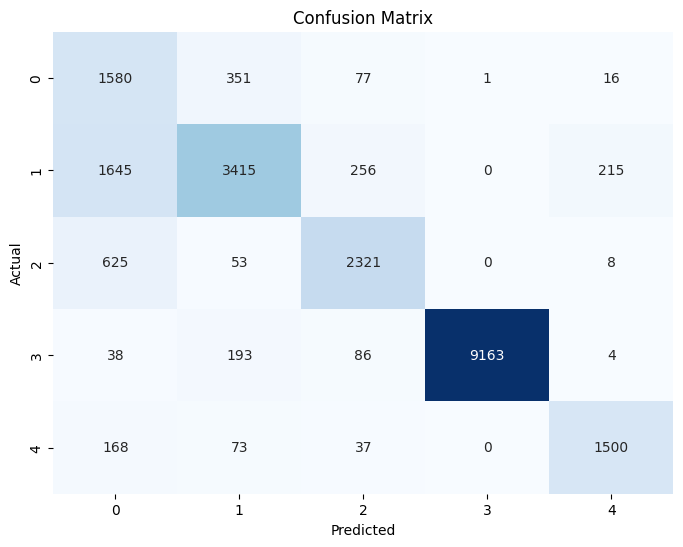

In [12]:
# Compute metrics for multi-class classification
f1 = f1_score(y_test, predictions, average='weighted')  # Macro average for multi-class
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, predictions)
# Display the report
print(report)

                precision    recall  f1-score   support

           DoS       0.39      0.78      0.52      2025
      Exploits       0.84      0.62      0.71      5531
       Fuzzers       0.84      0.77      0.80      3007
       Generic       1.00      0.97      0.98      9484
Reconnaissance       0.86      0.84      0.85      1778

      accuracy                           0.82     21825
     macro avg       0.78      0.80      0.77     21825
  weighted avg       0.87      0.82      0.84     21825



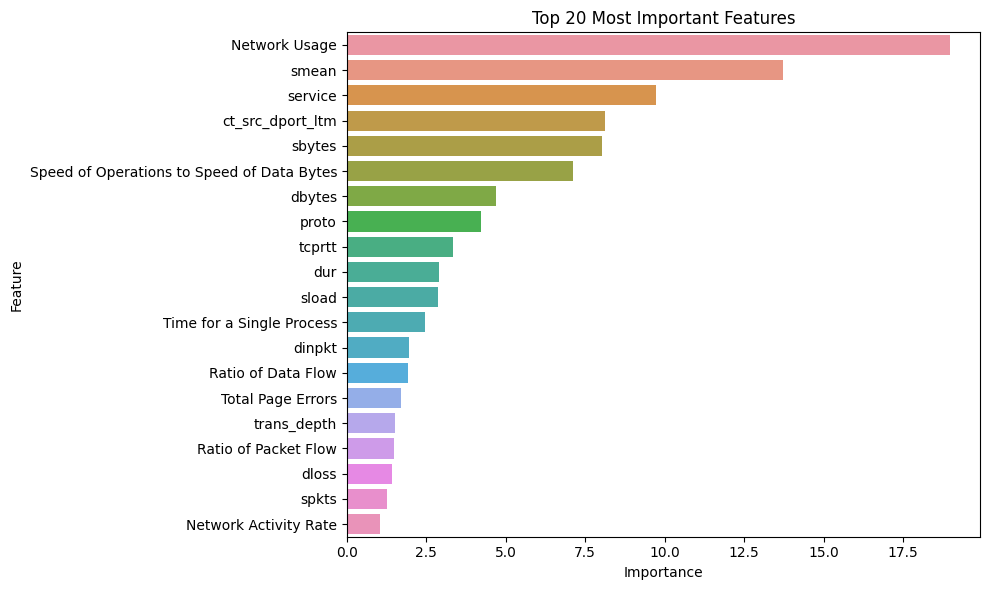

In [14]:
# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

def plot_feature_importance(top_n=20):
    """Plots the top N important features."""

    # Select top N features
    top_features = features_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance()